# **Vector Space Model (VSM) Evaluation Notebook**

## **Objective**
This notebook will serve as the testing site for comparing different **Vector Space Model (VSM) approaches** using various word embeddings.

## **Approaches Compared**
1. **Word2Vec Pretrained**  
2. **Word2Vec Fine-tuned (Pretrained + Own Data)**  
3. **Word2Vec Trained from Scratch on Own Data**  
4. **GloVe**  
5. **FastText**  

## **Evaluation Methods**
Each method will be evaluated using the following criteria:

### **A. Word Similarity Evaluation**
Measure the similarity between words using cosine similarity.

```python
print(word2vec_model.similarity("car", "vehicle"))
print(glove_model.similarity("car", "vehicle"))
print(custom_word2vec.wv.similarity("car", "vehicle"))
```

### **B. Document Vector Representation**
Compute document vectors by averaging the word embeddings of the words they contain.

```python
import numpy as np
from nltk.tokenize import word_tokenize

def get_document_vector(model, text):
    words = word_tokenize(text.lower())
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

doc_vector = get_document_vector(word2vec_model, "This is a test document.")
```

### **C. Clustering (K-Means)**
Cluster documents using K-Means clustering based on their computed document vectors.
```python
from sklearn.cluster import KMeans

# Example document vectors
doc_vectors = [get_document_vector(word2vec_model, doc) for doc in documents]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(doc_vectors)

print("Cluster assignments:", clusters)
```

### **D. Text Classification**
Use document embeddings as input for a classification model and evaluate its accuracy. (finally)


```python

```



--------------

In [8]:
import os
import numpy as np
import gensim.downloader as api

# Load the pretrained Word2Vec model
model = api.load("word2vec-google-news-300")  # Google's 300-dim Word2Vec

# Define the directory path
accessories_dir = "../02-data/00-testing/03-demo/"

# Initialize a dictionary to store document vectors
document_vectors = {}

# Iterate through all subdirectories
for root, _, _ in os.walk(accessories_dir):
    folder_name = os.path.basename(root)  # Folder name
    txt_filename = f"{folder_name}.txt"  # Expected text file name
    txt_path = os.path.join(root, txt_filename)

    try:
        # Read and preprocess the text file
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().split()  # Simple tokenization
    
        # Convert words to vectors
        word_vectors = [model[word] for word in text if word in model]
        
        # Compute document vector (mean of word embeddings)
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            doc_vector = np.zeros(model.vector_size)  # Default to zero vector if no words are found
        
        # Store the document vector using the file path as the key
        document_vectors[txt_filename] = doc_vector
        
    except FileNotFoundError:
        print(f"this folder does not have a .txt file {txt_filename}")
    
# Print summary
print(f"Processed {len(document_vectors)} documents.")

this folder does not have a .txt file .txt
this folder does not have a .txt file batteries-non-rechargable-primary.txt
this folder does not have a .txt file coaxial-cables-rf.txt
this folder does not have a .txt file microphones.txt
Processed 45 documents.


--------------------------------------------
Save the model for later (or load)

In [11]:
import pickle

# Save document_vectors to a file
with open("../02-data/00-testing/vsm3.pkl", "wb") as f:
    pickle.dump(document_vectors, f)


---------------------------------
This is the representation aspect of the code 

In [5]:
# Example: Assign colors based on directory or filename pattern
color_map = {
    "batteries-non-rechargable-primary": "red",
    "coaxial-cables-rf": "blue",
    "microphones": "green",
    "default": "black"  # Fallback color
}

def get_category_color(path):
    """Determine color based on file path."""
    if "batteries-non-rechargable-primary" in path:
        return color_map["batteries-non-rechargable-primary"]
    elif "coaxial-cables-rf" in path:
        return color_map["coaxial-cables-rf"]
    elif "microphones" in path:
        return color_map["microphones"]
    else:
        return color_map["default"]

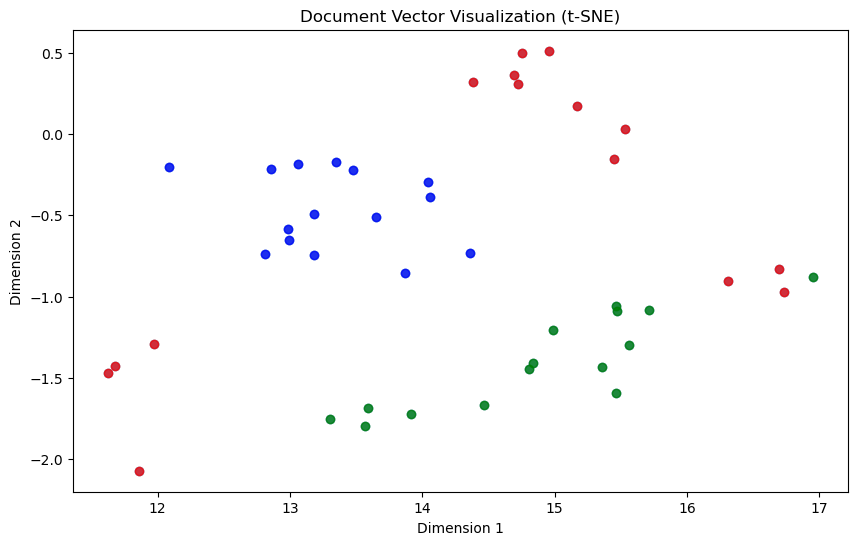

In [41]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pickle
import os

# Load document_vectors from a file
with open("../02-data/00-testing/word2vec-finetuned-demo.pkl", "rb") as f:
    document_vectors = pickle.load(f)
    
# Extract document vectors
doc_paths = list(document_vectors.keys())  # File paths as labels
doc_vectors = np.array(list(document_vectors.values()))  # Convert dict to array

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=min(30, len(doc_vectors) - 1), random_state=42)
doc_vectors_2d = tsne.fit_transform(doc_vectors)

# Plot the reduced vectors
plt.figure(figsize=(10, 6))
plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1], alpha=0.7)

for i, path in enumerate(doc_paths):
    color = get_category_color(path)  # Get color based on path
    plt.scatter(doc_vectors_2d[i, 0], doc_vectors_2d[i, 1], color=color, alpha=0.7)

    #if i % 5 == 0:  # Label every 5th document for readability
        #plt.annotate(os.path.basename(path), (doc_vectors_2d[i, 0], doc_vectors_2d[i, 1]))


plt.title("Document Vector Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


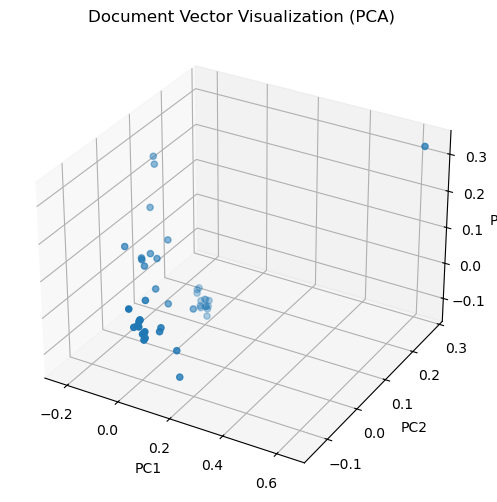

In [4]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D using PCA
pca = PCA(n_components=3)
doc_vectors_3d = pca.fit_transform(doc_vectors)

# Plot in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(doc_vectors_3d[:, 0], doc_vectors_3d[:, 1], doc_vectors_3d[:, 2])

ax.set_title("Document Vector Visualization (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


-------------------------------
How to "fine-tune" the word2vec?

1. Add the specific domain corpus to the main group of data
2. Retrain on this new extended corpus (adjust epochs and other variables)
3. Generate vectors as previously done

In [34]:
new_data = [['your', 'new', 'data', 'tokens'], ['another', 'set', 'of', 'tokens']]
model.build_vocab(new_data, update=True)
model.train(new_data, total_examples=model.corpus_count, epochs=model.epochs)


AttributeError: 'KeyedVectors' object has no attribute 'build_vocab'

In [ ]:
from gensim import downloader as api

import os
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Directory containing your text files
text_files_dir = "../02-data/01-pdfs/accessories"

# Collect all text data
sentences = []

for root, dirs, files in os.walk(text_files_dir):
    for file in files:
        if file.endswith(".txt"):  # Adjust if necessary
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip().lower() ## strip -removes leading and trailing whitespace.
                # Tokenize text (simple whitespace splitting, you could use nltk/spacy if more sophisticated tokenization is needed)
                sentences.append(text.split())

print(f"Collected {len(sentences)} documents.")

# Load the pretrained model
model = api.load("word2vec-google-news-300")

# Make the model trainable
model.init_sims(replace=True)  # Make the model's vectors mutable

# Update the model's vocabulary with new data
model.build_vocab(sentences, update=True) ## if a oov word appears (out-of-vocabulary) the word2vec skips the processing of said token. Wise to include it then

# Train the model on the new data
model.train(sentences, total_examples=len(sentences), epochs=model.epochs)

model.save("word2vec_finetuned.model") ## -> saves the model itself
model.wv.save("word2vec_finetuned.kv") ## -> saves the keyed vectors (if there is no need for further training)


## Now, use the model to create vector representations the same way as before --> look into 05-VSM


--------------------------------
Second try at this word2vec thing

In [33]:
## second try at finetuning a word2vec model

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')  # Ensure tokenization models are downloaded

# load glove model and transform into word2vec model
word2vec_path = "../02-data/03-VSM/word2vec_finetuned.txt"
glove_path = "../02-data/03-VSM/glove.6B/glove.6B.100d.txt"

glove2word2vec(glove_path, word2vec_path)

sents = []  # List to store tokenized sentences
text_files_dir = "../02-data/00-demo/"

# Traverse directory and process each text file
for root, dirs, files in os.walk(text_files_dir):
    for file in files:
        if file.endswith(".txt"):  # Adjust as needed
            file_path = os.path.join(root, file)

            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()

            # Tokenize text into sentences and then into words
            tokenized_sents = [word_tokenize(sent) for sent in sent_tokenize(text)]
            sents.extend(tokenized_sents)  # Add to the main list

[nltk_data] Downloading package punkt to /home/pablo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipykernel_53514/3060002292.py:16: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_path)


In [21]:
# ok, now, build up a word2vec model with own data
model = Word2Vec(vector_size=100, min_count=1)
model.build_vocab(sents)
total_examples = model.corpus_count

# Save the vocab of your dataset
vocab = list(model.wv.key_to_index.keys())

model_2 = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)

# Add the pre-trained model vocabulary
model.build_vocab([list(model_2.key_to_index.keys())], update=True)

# Load the pre-trained models embeddings
# note: if a word doesn't exist in the pre-trained vocabulary then it is left as is in the original model
model.intersect_word2vec_format(word2vec_path, binary=False, lockf=1.0)

AttributeError: 'Word2Vec' object has no attribute 'intersect_word2vec_format'

---------------------
The up one used gensim 3.x
LEts rewrite it for gensim 4.x


In [23]:
# Load the pretrained model
from gensim import downloader as api

import os
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = api.load("word2vec-google-news-300")
size = model.vector_size

In [27]:
w2vModel = Word2Vec(vector_size=300, min_count=5)
w2vModel.build_vocab(sents)
w2vModel.wv.vectors_lockf = np.ones(len(w2vModel.wv))
w2vModel.wv.intersect_word2vec_format('pretrained.bin', binary=True)

w2vModel.train(sents, total_examples=len(sents), epochs=...)


FileNotFoundError: [Errno 2] No such file or directory: 'pretrained.bin'

In [31]:
import os
import numpy as np
from gensim import downloader as api
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

nltk.download('punkt')  # Ensure necessary NLTK models are downloaded

# 1. Download Pretrained Word2Vec Model
pretrained_model_path = "../02-data/03-VSM/pretrained.bin"

if not os.path.exists(pretrained_model_path):  # Avoid re-downloading if already exists
    print("Downloading pre-trained Word2Vec model...")
    model = api.load("word2vec-google-news-300")  # Load Google News vectors (1.5GB)
    model.save_word2vec_format(pretrained_model_path, binary=True)  # Save as .bin
    print("Download complete and saved as 'pretrained.bin'.")

# 2. Load the Pretrained Model
print("Loading pretrained model...")
pretrained_wv = KeyedVectors.load_word2vec_format(pretrained_model_path, binary=True)
size = pretrained_wv.vector_size
print(f"Pretrained model loaded with vector size: {size}")


# 4. Initialize and Train New Word2Vec Model
w2vModel = Word2Vec(vector_size=size, min_count=5)
w2vModel.build_vocab(sents)

# 5. Lock Word Vectors for Training Stability
w2vModel.wv.vectors_lockf = np.ones(len(w2vModel.wv))

# 6. Integrate Pretrained Word2Vec Embeddings
print("Integrating pretrained word vectors...")
w2vModel.wv.intersect_word2vec_format(pretrained_model_path, binary=True, lockf=1.0)

# 7. Train on Your Own Data
print("Training model...")
w2vModel.train(sents, total_examples=len(sents), epochs=10)  # Adjust epochs as needed

print("Training complete.")


[nltk_data] Downloading package punkt to /home/pablo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Download complete and saved as 'pretrained.bin'.
Loading pretrained model...
Pretrained model loaded with vector size: 300
Integrating pretrained word vectors...
Training model...


RuntimeError: you must first build vocabulary before training the model

-------------------------------
fk me

In [35]:
nltk.download('punkt')  # Ensure tokenization models are downloaded

text_files_dir = "../02-data/00-testing/03-demo"  # Change to your actual directory path
sents = []  # List to store tokenized sentences

# Traverse directory and process each text file
for root, dirs, files in os.walk(text_files_dir):
    for file in files:
        if file.endswith(".txt"):  # Adjust as needed
            file_path = os.path.join(root, file)

            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()

            # Tokenize text into sentences and then into words
            tokenized_sents = [word_tokenize(sent) for sent in sent_tokenize(text)]
            sents.extend(tokenized_sents)  # Add to the main list

# Example output
print(sents[:5])  # Print first 5 tokenized sentences for verification

[nltk_data] Downloading package punkt to /home/pablo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['based', 'on', 'the', 'image', 'i', 'can', 'describe', 'the', 'elements', 'in', 'a', 'technical', 'manner', 'as', 'follows', 'the', 'image', 'appears', 'to', 'be', 'a', 'logo', 'or', 'branding', 'element', 'for', 'a', 'company', 'the', 'logo', 'consists', 'of', 'several', 'elements', 'which', 'can', 'be', 'described', 'as', 'follows', '1', 'shape', 'the', 'logo', 'features', 'a', 'circular', 'shape', 'which', 'is', 'a', 'common', 'symbol', 'for', 'unity', 'and', 'completeness', '2', 'color', 'scheme', 'the', 'logo', 'features', 'a', 'color', 'scheme', 'consisting', 'of', 'a', 'primary', 'color', 'blue', 'and', 'a', 'secondary', 'color', 'white', 'the', 'blue', 'color', 'is', 'a', 'dominant', 'color', 'while', 'the', 'white', 'color', 'is', 'used', 'as', 'an', 'accent', 'color', '3', 'typography', 'the', 'logo', 'features', 'a', 'custom', 'typography', 'which', 'is', 'a', 'sansserif', 'font', 'the', 'font', 'is', 'clean', 'and', 'modern', 'with', 'a', 'clear', 'and', 'legible', 'font'

In [39]:
import numpy as np
from nltk import word_tokenize
from gensim.models import Word2Vec, KeyedVectors


# Output: tokenized_sentences[0] = ['I', 'like', 'to', 'eat', 'broccoli', 'and', 'bananas', '.']

# Load pretrained model for finetuning
pretrained_model_path = "../02-data/03-VSM/pretrained.bin"
pretrained_model = KeyedVectors.load_word2vec_format(
    pretrained_model_path, binary=True)
pretrained_vocab = list(pretrained_model.index_to_key)

# Create new model
model = Word2Vec(vector_size=pretrained_model.vector_size)
model.build_vocab(sents)
total_examples = model.corpus_count
model_vocab = list(model.wv.index_to_key)

# Load pretrained model's vocabulary.
model.build_vocab([pretrained_vocab], update=True)

# vectors_lockf property is initialize in __init__ method of Word2Vec class.
# We are using build_vocab method to update vocabulary of model, so we need initialize vectors_lockf property manually.
model.wv.vectors_lockf = np.ones(len(model.wv), dtype=np.float32)

# load pretrained model's embeddings into model
model.wv.intersect_word2vec_format(pretrained_model_path, binary=True)

model.train(sents,
            total_examples=total_examples, epochs=model.epochs)

# References and see also:
# https://rare-technologies.com/word2vec-tutorial/
# https://stackoverflow.com/questions/67707418/index-out-of-bounds-error-with-gensim-4-0-1-word2vec-model
# For gensim 3.x -> https://czarrar.github.io/Gensim-Word2Vec/
# https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

(627065, 901900)

In [40]:
# Save only the word vectors in Word2Vec format (smaller file size, faster loading)
model.wv.save_word2vec_format("../02-data/03-VSM/word2vec_finetuned.bin", binary=True)


-------------------------------------
Now we are getting into other metrics (nearest neighbors for example)